In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import crepe
from scipy.interpolate import interp1d
from scipy.signal import argrelextrema
import pandas as pd
import plotly.graph_objects as go
import IPython.display as ipd
from sklearn.cluster import KMeans
from sklearn.manifold import SpectralEmbedding
from scipy.signal import find_peaks as scipy_find_peaks
import os

In [ ]:
"""In this we have extracted the vocals of each song from the Crepe model and saved them in a csv file, there is a log file that keeps track of the files that have already been processed, 
so that if you run the code again, it will not process the same files again.
The Master_Crepe.csv file contains the following columns:
Index, AudioPath, Tonic, Time, Frequency, Confidence 
In these columns, AudioPath and Frequency are the most important, AudioPath is the path to the audio file,
and Frequency is the frequency of the audio file at each time step.
Tonic is the tonic of the song, which is extracted from the filename, and Time is the time at which the frequency is measured.
"""
vocal_folder = "Vocals_file"
output_csv = "Master_Crepe.csv"
log_csv = "Crepe_log.csv"

# === LOAD OR CREATE LOG FILE ===
if os.path.exists(log_csv):
    processed_files = set(pd.read_csv(log_csv)["AudioPath"].values)
else:
    processed_files = set()

# === START INDEX FROM LAST INDEX + 1 ===
if os.path.exists(output_csv):
    df_existing = pd.read_csv(output_csv)
    current_index = df_existing["Index"].max() + 1
else:
    with open(output_csv, "w") as f:
        f.write("Index,AudioPath,Tonic,Time,Frequency,Confidence\n")
    current_index = 1

new_log_entries = []

# === PROCESS WAV FILES ===
for filename in os.listdir(vocal_folder):
    if not filename.lower().endswith(".wav"):
        continue

    audio_path = os.path.join(vocal_folder, filename)

    if audio_path in processed_files:
        print(f"🟡 Skipping already processed file: {filename}")
        continue

    print(f"🔧 Processing new file: {filename}")

    tonic = filename.rsplit("_", 1)[-1].replace(".wav", "")
    y, sr = librosa.load(audio_path, sr=44100)

    # CREPE pitch estimation
    time, frequency, confidence, _ = crepe.predict(y, sr, viterbi=True, step_size=20, model_capacity="tiny")

    spec_time = librosa.times_like(librosa.stft(y), sr=sr)
    interp_freq = interp1d(time, frequency, kind='linear', fill_value='extrapolate')
    interp_conf = interp1d(time, confidence, kind='linear', fill_value='extrapolate')

    new_frequency = interp_freq(spec_time)
    new_confidence = interp_conf(spec_time)

    # Save current song's data immediately
    df_single = pd.DataFrame({
        "Index": current_index,
        "AudioPath": audio_path,
        "Tonic": tonic,
        "Time": spec_time,
        "Frequency": new_frequency,
        "Confidence": new_confidence
    })

    df_single.to_csv(output_csv, mode='a', index=False, header=False)
    new_log_entries.append(audio_path)
    current_index += 1
    print(f"✅ Done with: {filename}")

# === UPDATE LOG ===
if new_log_entries:
    log_df = pd.DataFrame({"AudioPath": new_log_entries})
    log_df.to_csv(log_csv, mode='a', index=False, header=not os.path.exists(log_csv))

print("🎉 All new files processed and saved.")


🟡 Skipping already processed file: Evari_Bodhana_C#3.wav
🟡 Skipping already processed file: Mohana_Raaga_D3.wav
🟡 Skipping already processed file: Sahana_Raaga_C#3.wav
🟡 Skipping already processed file: Sahana_Raaga_G3.wav
🟡 Skipping already processed file: Saveri_Raaga_G#3.wav
🟡 Skipping already processed file: Sri_Raaga_C#3.wav
🟡 Skipping already processed file: Sri_Raaga_D3.wav
🎉 All new files processed and saved.


In [19]:
def plot_spectrogram_with_crepe(spec_time, conf, S_db, sr):
    plt.figure(figsize=(14, 8))
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='linear', cmap='viridis')
    plt.plot(spec_time, conf, color='r', linewidth=1.5, label='CREPE Pitch')  # Use spec_time
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.ylim(0, 2000)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
    
def find_tonic(S, sr):
    chroma = librosa.feature.chroma_stft(S=np.abs(S), sr=sr)
    pitch_class_sums = np.sum(np.abs(chroma), axis=1)
    pitch_labels = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
    pitch_class_dict = dict(zip(pitch_labels, pitch_class_sums))
    return max(pitch_class_dict, key=pitch_class_dict.get)

def get_carnatic_frequencies(tonic):
    # Intonational ratios for the basic set of Carnatic notes
    carnatic_ratios = {
        'sa': 0.5*1.0,    # Tonic (Sa)
        'ri1': 0.5*16/15, # Ri1
        'ri2': 0.5*9/8,  # Ri2
        'ga1': 0.5*6/5,  # Ga1
        'ga2': 0.5*5/4, # Ga2
        'ma1': 0.5*4/3, # Ma1
        'ma2': 0.5*45/32,   # Ma2
        'pa': 0.5*3/2,    # Pa
        'da1': 0.5*8/5, # Dha1
        'da2': 0.5*5/3, # Dha2
        'ni1': 0.5*16/9, # Ni1
        'ni2': 0.5*15/8,   # Ni2

        'Sa': 1.0,    # Tonic (Sa)
        'Ri1': 16/15, # Ri1
        'Ri2': 9/8,  # Ri2
        'Ga1': 6/5,  # Ga1
        'Ga2': 5/4, # Ga2
        'Ma1': 4/3, # Ma1
        'Ma2': 45/32,   # Ma2
        'Pa': 3/2,    # Pa
        'Da1': 8/5, # Dha1
        'Da2': 5/3, # Dha2
        'Ni1': 16/9, # Ni1
        'Ni2': 15/8,   # Ni2

        'SA': 2.0,   # Octave higher (Sa)
        'RI1': 2*16/15, # Ri1
        'RI2': 2*9/8,  # Ri2
        'GA1': 2*6/5,  # Ga1
        'GA2': 2*5/4, # Ga2
        'MA1': 2*4/3, # Ma1
        'MA2': 2*45/32,   # Ma2
        'PA': 2*3/2,    # Pa
        'DA1': 2*8/5, # Dha1
        'DA2': 2*5/3, # Dha2
        'NI1': 2*16/9, # Ni1
        'NI2': 2*15/8,   
    }

    tonic_freq = librosa.note_to_hz(tonic)  # Get the frequency of the tonic

    # Calculate the frequencies for each Carnatic note relative to the tonic
    carnatic_frequencies = {note: tonic_freq * ratio for note, ratio in carnatic_ratios.items()}
    return carnatic_frequencies

def get_closest_note(freq, carnatic_frequencies):
    """Find the closest Carnatic note for a given frequency."""
    return min(carnatic_frequencies, key=lambda note: abs(carnatic_frequencies[note] - freq))

def get_closest_frequency(freq, carnatic_frequencies):
    """Find the closest Carnatic note frequency for a given frequency."""
    return min(carnatic_frequencies.values(), key=lambda f: abs(f - freq))

def get_index_from_time(time_input,conf):
    # Define the start and end times
    total_duration = end_time - start_time
    num_pieces = len(conf)
    
    # Calculate the duration of each piece
    duration_per_piece = total_duration / num_pieces
    
    # Check if the input time is within the valid range
    if time_input < start_time or time_input > end_time:
        raise ValueError(f"Input time must be between {start_time} and {end_time} seconds.")
    
    # Calculate the index
    index = int((time_input - start_time) / duration_per_piece)
    
    return index

def plot_frequency_with_carnatic_notes(frequency_list, beat_frames, tonic,beat_sr):
    beat_frames= librosa.frames_to_time(beat_frames, sr=beat_sr)
    loc_extremes = np.where(np.diff(np.sign(np.diff(frequency_list, prepend=np.nan, append=np.nan))) != 0)[0]
    extremes = frequency_list[loc_extremes].tolist()
    angles = np.degrees(np.arctan(np.diff(frequency_list, prepend=np.nan, append=np.nan) / 2))
    # notelist = [(conf[i], i, angles[i], angles[i + 1], i in loc_extremes) for i in range(len(conf) - 1)]
    carnatic_frequencies = get_carnatic_frequencies(tonic)
    frequency_array = np.array(frequency_list)
    
    beat_points=[]
    for i in beat_frames:
        if i < start_time or i > end_time:
            continue
        beat_points.append(get_index_from_time(i,frequency_list))




    # Identify valid (non-NaN) frames
    valid_indices = ~np.isnan(frequency_array)  
    valid_frequencies = frequency_array[valid_indices]
    if len(valid_frequencies) == 0:
        raise ValueError("No valid frequencies to process.")

    carnatic_frequencies = get_carnatic_frequencies(tonic)

    # Plot the graph
    fig = go.Figure()

    # Plot the frequency graph with gaps for NaNs
    for start, end in zip(
        np.where(np.diff(np.concatenate(([0], valid_indices, [0]))) == 1)[0],
        np.where(np.diff(np.concatenate(([0], valid_indices, [0]))) == -1)[0]
    ):
        fig.add_trace(go.Scatter(
            x=np.arange(start, end),
            y=frequency_array[start:end],
            mode='lines',
            name='Frequency (Hz)',
            line=dict(color='blue')
        ))

    # Plot horizontal lines for Carnatic notes
    for note, freq in carnatic_frequencies.items():
        fig.add_trace(go.Scatter(
            x=[0, len(frequency_list) - 1],
            y=[freq, freq],
            mode='lines',
            line=dict(dash='dash', color='gray', width=2),
            name=note,
            hovertemplate=f"{note} ({freq:.2f} Hz)"
        ))

    # Plot the extremes as red dots
    fig.add_trace(go.Scatter(
        x=loc_extremes,
        y=extremes,
        mode='markers',
        marker=dict(color='red', size=2, symbol='circle'),
        name='Extremes'
    ))

    # Plot vertical lines for beat points
    for beat in beat_points:
        fig.add_trace(go.Scatter(
            x=[beat, beat],  # Vertical line at 'beat'
            y=[np.nanmin(frequency_array), np.nanmax(frequency_array)],  # Full y-range
            mode='lines',
            line=dict(color='orange', width=2),
            name=f'Beat @ {beat}'
        ))

    fig.update_layout(
        title=f'Frequency with Carnatic Notes (Tonic: {tonic})',
        xaxis_title='Time',
        yaxis_title='Frequency (Hz)',
        showlegend=True
    )

    fig.show()

def breaklist(elements, indexes):
    segmented_lists = []
    start_index = 0  

    for idx in indexes:
        segment = elements[start_index:idx]
        segmented_lists.append(segment)
        start_index = idx  
    if start_index < len(elements):
        segmented_lists.append(elements[start_index:])

    return segmented_lists

def plot_with_carnatic_bars(note_num, noteslist, carnatic_frequencies):
    bars = list(carnatic_frequencies.values())
    
    # Find relevant frequency range
    min_freq = get_closest_frequency(np.nanmin(noteslist[note_num]), carnatic_frequencies)
    max_freq = get_closest_frequency(np.nanmax(noteslist[note_num]), carnatic_frequencies)
    
    # Filter bars within the frequency range
    newbars = [i for i in bars if min_freq <= i <= max_freq]
    
    # Plot
    plt.plot(noteslist[note_num])
    for i in newbars:
        plt.axhline(y=i, color='r', linestyle='--')
    plt.show()
    for i in newbars:
        print(get_closest_note(i, carnatic_frequencies))

def spectral_decomp(note, n_clusters, plot=True):
    note = np.array(note)
    X = np.column_stack((np.arange(len(note)), note))
    embedding = SpectralEmbedding(n_components=2, affinity='nearest_neighbors')
    X_transformed = embedding.fit_transform(X)

    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_transformed)

    # Sort clusters based on first occurrence
    unique_clusters = np.unique(labels, return_index=True)
    sorted_clusters = [cluster for _, cluster in sorted(zip(unique_clusters[1], unique_clusters[0]))]
    label_mapping = {old: new for new, old in enumerate(sorted_clusters)}
    sorted_labels = np.array([label_mapping[label] for label in labels])

    # Assign frequencies to clusters
    segments = [[] for _ in range(n_clusters)]
    for idx, freq in enumerate(note):
        segments[sorted_labels[idx]].append((idx, freq))

    if plot:
        fig = go.Figure()

        colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta']
        for i in range(n_clusters):
            indices, freqs = zip(*segments[i]) if segments[i] else ([], [])
            fig.add_trace(go.Scatter(
                x=indices,
                y=freqs,
                mode='markers+lines',
                marker=dict(size=6, color=colors[i % len(colors)]),
            ))

        # Plot horizontal lines at each unique frequency

        unique_freqs = [i for i in get_carnatic_frequencies("C#3").values() if min(note) <= i <= max(note)]
        unique_notes= [i for i in get_carnatic_frequencies("C#3").keys() if min(note) <= get_carnatic_frequencies("C#3")[i] <= max(note)]
        x_values = np.linspace(min(X[:, 0]), max(X[:, 0]), num=100)  # Densely spaced x values

        for i in range (len( unique_freqs)):
            y_values = np.full_like(x_values,unique_freqs[i])
            fig.add_trace(go.Scatter(
                x=x_values,
                y=y_values,
                mode="lines",
                line=dict(color="gray", dash="dash"),
                showlegend=False,
                hovertemplate=f"{unique_notes[i]}({unique_freqs[i]:.2f} Hz)"
            ))

        
        fig.show()

    return [list(zip(*seg))[1] if seg else [] for seg in segments] 

def playnote(n, beat_audio, beat_sr, beat_times, start_time):
    adjusted_beat_times = beat_times - start_time
    adjusted_beat_times = adjusted_beat_times[adjusted_beat_times >= 0]  # Remove negative times
    if n < 0 or n >= len(adjusted_beat_times) - 1:
        print("Invalid note index")
        return
    note_start_time = adjusted_beat_times[n]
    note_end_time = adjusted_beat_times[n+1]
    start_sample = int(note_start_time * beat_sr)
    end_sample = int(note_end_time * beat_sr)

    note_audio = beat_audio[start_sample:end_sample]
    ipd.display(ipd.Audio(note_audio, rate=beat_sr))

def find_peaks_and_valleys(conf):
    peaks = []
    valleys = []
    
    for i in range(1, len(conf) - 1):
        if not np.isnan(conf[i-1]) and not np.isnan(conf[i]) and not np.isnan(conf[i+1]):
            if conf[i] > conf[i-1] and conf[i] > conf[i+1]:
                peaks.append(i)
            elif conf[i] < conf[i-1] and conf[i] < conf[i+1]:
                valleys.append(i)
    
    return peaks, valleys

def play_segment_between_beats(beat_audio, beat_sr, beat_frames, beat_index,offset=0):
    # Ensure the beat_index is valid
    if beat_index < 0 or beat_index >= len(beat_frames) - 1:
        print("Invalid beat index. Please provide a valid index.")
        return

    # Get the start and end frames for the segment
    start_frame = beat_frames[beat_index-offset]
    end_frame = beat_frames[beat_index + 1+offset]

    # Convert frames to time
    start_time = librosa.frames_to_time(start_frame, sr=beat_sr)
    end_time = librosa.frames_to_time(end_frame, sr=beat_sr)

    # Convert time to sample indices
    start_sample = int(start_time * beat_sr)
    end_sample = int(end_time * beat_sr)

    # Slice the audio segment
    audio_segment = beat_audio[start_sample:end_sample]

    # Play the audio segment
    ipd.display(ipd.Audio(audio_segment, rate=beat_sr))

def trim(data):
    data = np.array(data)  
    valid_indices = np.where(~np.isnan(data))[0]
    valid_data = data[valid_indices]
    peaks = argrelextrema(valid_data, np.greater, order=2)[0]

    troughs = argrelextrema(valid_data, np.less, order=2)[0]

    # Combine peaks & troughs and sort them
    extrema = np.sort(np.concatenate((peaks, troughs)))

    if len(extrema) < 2:
        return data  # Not enough peaks/troughs to trim

    # Find start and end positions in original indices
    start, end = valid_indices[extrema[0]], valid_indices[extrema[-1]]

    return data[start:end+1]

def shift_beats_to_peaks_or_valleys(beat_frames, conf):
    """
    Shift the beat frames to align with the nearest peak or valley in the confidence array.
    
    Parameters:
    - beat_frames: The original beat frames.
    - conf: The confidence array.
    
    Returns:
    - shifted_beat_frames: The updated beat frames.
    """
    peaks, valleys = find_peaks_and_valleys(conf)
    shifted_beat_frames = []

    for beat in beat_frames:
        # Find the nearest peak or valley
        nearest_index = None
        min_distance = float('inf')

        for index in peaks + valleys:
            distance = abs(index - beat)
            if distance < min_distance:
                min_distance = distance
                nearest_index = index

        shifted_beat_frames.append(nearest_index)

    return np.array(shifted_beat_frames)

def extend_sublists(main_list, num=4):
    extended_list = []
    for i in range(len(main_list)):
        current_sublist = main_list[i]
        if i == 0 or i == len(main_list) - 1:
            extended_list.append(current_sublist)
        else:
            new_sublist = []
            new_sublist.extend(main_list[i - 1][-num:])
            new_sublist.extend(current_sublist)
            new_sublist.extend(main_list[i + 1][:num])
            extended_list.append(new_sublist)
    return extended_list

def plot_with_carnatic_bars_with_peaks(segment, carnatic_frequencies, color='lime'):
    plt.style.use('dark_background')  # Dark mode

    bars = list(carnatic_frequencies.values())

    # Find relevant frequency range
    min_freq = get_closest_frequency(np.nanmin(segment), carnatic_frequencies)
    max_freq = get_closest_frequency(np.nanmax(segment), carnatic_frequencies)
    newbars = [i for i in bars if min_freq <= i <= max_freq]

    plt.figure(figsize=(12, 6))
    x_vals = np.arange(len(segment))
    plt.scatter(x_vals, segment, s=8, color=color)

    # Peaks and valleys
    peaks, _ = scipy_find_peaks(segment)
    valleys, _ = scipy_find_peaks(-np.array(segment))
    plt.plot(peaks, segment[peaks], "o", markersize=4, color="cyan", label="Peaks/Valleys")
    plt.plot(valleys, segment[valleys], "o", markersize=4, color="cyan")

    # Plot Carnatic bars with labels
    for freq in newbars:
        note = get_closest_note(freq, carnatic_frequencies)
        plt.axhline(y=freq, color='orange', linestyle='--', linewidth=0.8)
        plt.text(0, freq, note, color='orange', fontsize=9, verticalalignment='bottom')

    plt.xlabel("Frame Index")
    plt.ylabel("Frequency (Hz)")
    plt.title("Segment with Peaks, Valleys, and Carnatic Frequency Bars")
    plt.tight_layout()
    plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
    plt.show()

def interpolate_with_nans(data, target_length=128):

    data = np.array(data, dtype=np.float64)
    original_length = len(data)
    x_original = np.linspace(0, 1, original_length)
    x_target = np.linspace(0, 1, target_length)
    valid = ~np.isnan(data)
    if np.count_nonzero(valid) < 2:
        return np.full(target_length, np.nan)
    interpolator = interp1d(x_original[valid], data[valid], kind='linear', bounds_error=False, fill_value="extrapolate")
    interpolated = interpolator(x_target)
    nan_mask_original = np.isnan(data)
    nan_mask_interpolated = np.interp(x_target, x_original, nan_mask_original.astype(float)) > 0.5
    interpolated[nan_mask_interpolated] = np.nan
    return interpolated

def play_segment(beat_audio, beat_sr, start_frame,end_frame):
    # Ensure the beat_index is valid


    # Convert frames to time
    start_time = librosa.frames_to_time(start_frame, sr=beat_sr)
    end_time = librosa.frames_to_time(end_frame, sr=beat_sr)

    # Convert time to sample indices
    start_sample = int(start_time * beat_sr)
    end_sample = int(end_time * beat_sr)

    # Slice the audio segment
    audio_segment = beat_audio[start_sample:end_sample]

    # Play the audio segment
    ipd.display(ipd.Audio(audio_segment, rate=beat_sr))

In [ ]:
"""
This code adds a new column to the Master_Crepe.csv file that normalizes the frequency values based on the tonic of each song."""

import pandas as pd
df = pd.read_csv("Master_Crepe.csv")
normalized_values = []
for tonic, freq in zip(df["Tonic"], df["Frequency"]):
    base = get_carnatic_frequencies(tonic)["Sa"]
    if base and base > 0:
        normalized_values.append(freq / base)
    else:
        normalized_values.append(None)  # or np.nan

df["Tonic_Normalized_Frequency"] = normalized_values
df.to_csv("Master_Crepe.csv", index=False)
print("✅ Tonic_Normalized_Frequency column added.")


✅ Tonic_Normalized_Frequency column added.


In [ ]:
"The normalized frequency values are now saved in a list.. this is for all the songs... since they have been tonic normalized"
"they can be compared."


csv_path = "Master_Crepe.csv"
new_confidence = pd.read_csv(csv_path)["Confidence"].values
new_frequency = pd.read_csv(csv_path)["Frequency"].values
spec_time = pd.read_csv(csv_path)["Time"].values
normalized_frequency = pd.read_csv(csv_path)["Tonic_Normalized_Frequency"].values
print(len(new_frequency))

264474


In [ ]:
# rmse = librosa.feature.rms(y=y, frame_length=2048, hop_length=512)[0]
# conf_thresh = 0  # Confidence threshold
# rmse_thresh = np.percentile(rmse, 7)  # Reject bottom 20% of RMSE energy
# conf = np.where(new_confidence > conf_thresh, new_frequency, np.nan)
# conf[rmse < rmse_thresh] = np.nan  # Reject frames with low energy  
# print(len(conf))
tonic_normalized_conf=normalized_frequency
conf = new_frequency

In [1]:
#First Time of Dynamic time Warping 
""" Here we create functions to extract repeating segments for one songe, by using DTW and slowly reducing the window size to give priority to bigger
patterns and then smaller patterns 
the extract_notes_from_conf function takes the frequency array and extracts segments of repeating notes based on DTW distance."""

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.spatial.distance import cdist
from fastdtw import fastdtw
from sklearn.cluster import AgglomerativeClustering
from collections import Counter, defaultdict

def non_overlapping_segments(conf, window_size, hop_size):
    segments = []
    indices = []
    i = 0
    while i < len(conf) - window_size:
        segment = conf[i:i + window_size]
        if np.isnan(segment).any():
            i += hop_size
            continue
        segments.append(segment)
        indices.append(i)
        i += window_size  # skip all overlapping windows
    return np.array(segments), np.array(indices)

def dtw_distance_matrix(segments):
    n = len(segments)
    dists = np.zeros((n, n))
    for i in tqdm(range(n)):
        for j in range(i+1, n):
            dist, _ = fastdtw(segments[i], segments[j])
            dists[i, j] = dist
            dists[j, i] = dist
    return dists

def extract_notes_from_conf(conf, initial_window_size, decay_size, min_window_size, outlier_threshold,similairity_threshold=100):
    conf = conf.copy()
    remaining_conf = conf.copy()
    all_removed_segments = []

    window_size = initial_window_size
    global_label_offset = 0

    total_iters = (initial_window_size - min_window_size) // decay_size + 1
    iter_count = 0

    while window_size >= min_window_size:
        iter_count += 1
        print(f"Iteration {iter_count}/{total_iters} — Window Size: {window_size}")

        hop_size = int(window_size / 12)
        segments, segment_starts = non_overlapping_segments(remaining_conf, window_size, hop_size)
        
        if len(segments) == 0:
            print("  Skipped — no valid segments")
            window_size -= decay_size
            continue

        dtw_dists = dtw_distance_matrix(segments)

        if len(segments) < 2:
            return remaining_conf, all_removed_segments  # <-- add this safeguard

        clustering = AgglomerativeClustering(
            n_clusters=None,
            distance_threshold=similairity_threshold,
            metric='precomputed',
            linkage='average'
        )
        labels = clustering.fit_predict(dtw_dists)
        labels = clustering.fit_predict(dtw_dists)

        cluster_dict = defaultdict(list)
        cluster_origins = defaultdict(list)

        for seg, start_idx, lbl in zip(segments, segment_starts, labels):
            cluster_dict[lbl].append(seg)
            cluster_origins[lbl].append(start_idx)

        clustered = False
        for label, starts in cluster_origins.items():
            if len(starts) >= outlier_threshold:
                clustered = True
                global_label = global_label_offset + label
                for i in starts:
                    remaining_conf[i:i + window_size] = np.full(window_size, np.nan)
                    all_removed_segments.append([i, i + window_size, global_label])

        if clustered:
            print(f"  Clusters found: {len(set(labels))}, removed some segments.")
        else:
            print(f"  Clusters found: {len(set(labels))}, but none met the threshold.")

        global_label_offset += len(set(labels))
        window_size -= decay_size

    return remaining_conf, all_removed_segments

def plot_colored_segments(original_conf, removed_segments, residual_conf=None):
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import matplotlib.colors as mcolors

    # Assign a color to each cluster
    cluster_labels = sorted(set(lbl for _, _, lbl in removed_segments))
    cmap = cm.get_cmap('tab20', len(cluster_labels))
    cluster_to_color = {label: cmap(i) for i, label in enumerate(cluster_labels)}

    plt.figure(figsize=(14, 5))
    plt.plot(original_conf, label="Original", alpha=0.2, color='gray')

    # Plot segments grouped by cluster label
    for start, end, label in removed_segments:
        plt.plot(range(start, end), original_conf[start:end], color=cluster_to_color[label], label=f"Cluster {label}")

    # Plot residual if given
    if residual_conf is not None:
        plt.plot(residual_conf, label="Residual", linewidth=2, color='black')

    # Create a legend without duplicate labels
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.title("Clusters of Repeating Notes")
    plt.xlabel("Time Index")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# conf_start_index = 0 # this is the slice offset
# residual_conf, removed_segments_local = extract_notes_from_conf(
#     tonic_normalized_conf[conf_start_index:conf_start_index+28588],
#     initial_window_size=60,
#     decay_size=2,
#     min_window_size=15,
#     outlier_threshold=2,
#     similairity_threshold=0.5
# )
# print(removed_segments_local)
# plot_colored_segments(tonic_normalized_conf[conf_start_index:conf_start_index+28588], removed_segments_local, residual_conf)

# # unique_cluster_labels = set(label for _, _, label in removed_segments)
# # print("Number of clusters:", len(unique_cluster_labels))
# removed_segments = [
#     (start + conf_start_index, end + conf_start_index, label)
#     for (start, end, label) in removed_segments_local
# ]

In [ ]:
#First Time of Dynamic time Warping
from tqdm import tqdm
from scipy.spatial.distance import cdist
from fastdtw import fastdtw
from sklearn.cluster import AgglomerativeClustering
from collections import Counter, defaultdict
from joblib import Parallel, delayed
import pandas as pd, numpy as np, json, os
from pathlib import Path

MASTER = "Master_Crepe.csv"
CARVA  = "carva.csv"
N_JOBS = os.cpu_count()        # change to e.g. 4 to pin the pool size
df_master = pd.read_csv(MASTER)

def non_overlapping_segments(conf, window_size, hop_size):
    segments = []
    indices = []
    i = 0
    while i < len(conf) - window_size:
        segment = conf[i:i + window_size]
        if np.isnan(segment).any():
            i += hop_size
            continue
        segments.append(segment)
        indices.append(i)
        i += window_size  # skip all overlapping windows
    return np.array(segments), np.array(indices)

def dtw_distance_matrix(segments):
    n = len(segments)
    dists = np.zeros((n, n))
    for i in tqdm(range(n)):
        for j in range(i+1, n):
            dist, _ = fastdtw(segments[i], segments[j])
            dists[i, j] = dist
            dists[j, i] = dist
    return dists

def extract_notes_from_conf(conf, initial_window_size, decay_size, min_window_size, outlier_threshold,similairity_threshold=100):
    conf = conf.copy()
    remaining_conf = conf.copy()
    all_removed_segments = []

    window_size = initial_window_size
    global_label_offset = 0

    total_iters = (initial_window_size - min_window_size) // decay_size + 1
    iter_count = 0

    while window_size >= min_window_size:
        iter_count += 1
        print(f"Iteration {iter_count}/{total_iters} — Window Size: {window_size}")

        hop_size = int(window_size / 12)
        segments, segment_starts = non_overlapping_segments(remaining_conf, window_size, hop_size)
        
        if len(segments) == 0:
            print("  Skipped — no valid segments")
            window_size -= decay_size
            continue

        dtw_dists = dtw_distance_matrix(segments)

        if len(segments) < 2:
            return remaining_conf, all_removed_segments  # <-- add this safeguard

        clustering = AgglomerativeClustering(
            n_clusters=None,
            distance_threshold=similairity_threshold,
            metric='precomputed',
            linkage='average'
        )
        labels = clustering.fit_predict(dtw_dists)
        labels = clustering.fit_predict(dtw_dists)

        cluster_dict = defaultdict(list)
        cluster_origins = defaultdict(list)

        for seg, start_idx, lbl in zip(segments, segment_starts, labels):
            cluster_dict[lbl].append(seg)
            cluster_origins[lbl].append(start_idx)

        clustered = False
        for label, starts in cluster_origins.items():
            if len(starts) >= outlier_threshold:
                clustered = True
                global_label = global_label_offset + label
                for i in starts:
                    remaining_conf[i:i + window_size] = np.full(window_size, np.nan)
                    all_removed_segments.append([i, i + window_size, global_label])

        if clustered:
            print(f"  Clusters found: {len(set(labels))}, removed some segments.")
        else:
            print(f"  Clusters found: {len(set(labels))}, but none met the threshold.")

        global_label_offset += len(set(labels))
        window_size -= decay_size

    return remaining_conf, all_removed_segments

def plot_colored_segments(original_conf, removed_segments, residual_conf=None):
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import matplotlib.colors as mcolors

    # Assign a color to each cluster
    cluster_labels = sorted(set(lbl for _, _, lbl in removed_segments))
    cmap = cm.get_cmap('tab20', len(cluster_labels))
    cluster_to_color = {label: cmap(i) for i, label in enumerate(cluster_labels)}

    plt.figure(figsize=(14, 5))
    plt.plot(original_conf, label="Original", alpha=0.2, color='gray')

    # Plot segments grouped by cluster label
    for start, end, label in removed_segments:
        plt.plot(range(start, end), original_conf[start:end], color=cluster_to_color[label], label=f"Cluster {label}")

    # Plot residual if given
    if residual_conf is not None:
        plt.plot(residual_conf, label="Residual", linewidth=2, color='black')

    # Create a legend without duplicate labels
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.title("Clusters of Repeating Notes")
    plt.xlabel("Time Index")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def remap_cluster_labels(removed_segments):
    old_labels = sorted(set(lbl for _, _, lbl in removed_segments))
    label_map  = {old: new for new, old in enumerate(old_labels)}
    return [(s, e, label_map[lbl]) for s, e, lbl in removed_segments]

def process_one_song(song_idx):
    """Worker: returns a list[dict] for one song."""
    song_df   = df_master[df_master["Index"] == song_idx].reset_index(drop=True)
    audio_path = song_df.loc[0, "AudioPath"]
    tonic_norm = song_df["Tonic_Normalized_Frequency"].values

    residual_conf, removed_segments_local = extract_notes_from_conf(
        tonic_norm,
        initial_window_size = 60,
        decay_size          = 2,
        min_window_size     = 15,
        outlier_threshold   = 2,
        similairity_threshold = 0.5
    )

    rows = []
    for start, end, lbl in remap_cluster_labels(removed_segments_local):
        rows.append({
            "Index"      : int(song_idx),
            "AudioPath"  : audio_path,
            "SegmentList": json.dumps(tonic_norm[start:end].tolist()),
            "StartFrame" : int(start),
            "EndFrame"   : int(end - 1),
            "Label"      : lbl
        })
    return rows

# ------------- parallel map -------------
song_indices = sorted(df_master["Index"].unique())

results = Parallel(n_jobs=N_JOBS, backend="loky")(
            delayed(process_one_song)(idx) for idx in tqdm(song_indices)
          )

# flatten list‑of‑lists -> list‑of‑dicts
flat_rows = [row for song_rows in results for row in song_rows]
carva_df  = pd.DataFrame(flat_rows)

# ------------- write / append -------------
if Path(CARVA).exists():
    carva_df.to_csv(CARVA, mode="a", index=False, header=False)
else:
    carva_df.to_csv(CARVA, index=False)

print(f"✅ Parallel run finished — {len(carva_df)} segments across {len(song_indices)} songs saved to {CARVA}")


100%|██████████| 7/7 [00:00<00:00, 270.91it/s]


KeyboardInterrupt: 

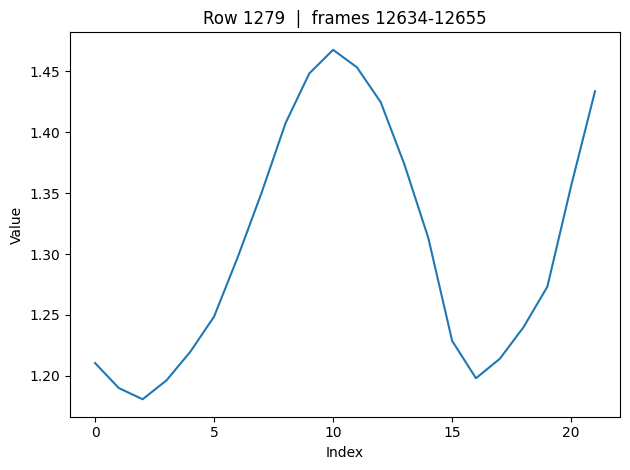

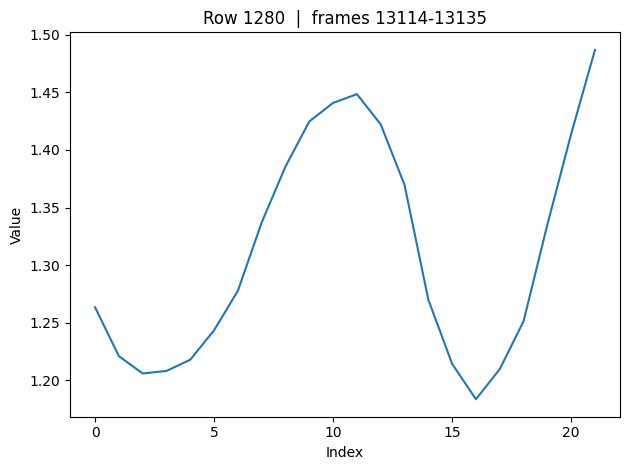

In [22]:
import ast           # safe literal‑string‑to‑python converter
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

CARVA = "carva.csv"
carvae = pd.read_csv(CARVA)

# ---- fix SegmentList column ---------------------------------
carvae["SegmentList"] = carvae["SegmentList"].apply(
    lambda s: ast.literal_eval(s) if isinstance(s, str) else s
)
# -------------------------------------------------------------
notes = carvae[(carvae["Label"] == 200) & (carvae["Index"] == 2)]

df=pd.read_csv("Master_Crepe.csv")
for i, row in notes.iterrows():
    seg = np.asarray(row.SegmentList, dtype=float)   # 1‑D array
    plt.figure()
    plt.plot(np.arange(seg.size), seg)               # index vs value
    plt.title(f"Row {i}  |  frames {row.StartFrame}-{row.EndFrame}")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.tight_layout()
    plt.show()
    y, sr = librosa.load(row.AudioPath, sr=44100)
    play_segment(y, sr, row.StartFrame, row.EndFrame)




In [10]:
import librosa
import matplotlib.pyplot as plt
import IPython.display as ipd

# Caches loaded audio files to avoid reloading
audio_cache = {}

def load_audio(audio_path):
    if audio_path not in audio_cache:
        y, sr = librosa.load(audio_path, sr=None)
        audio_cache[audio_path] = (y, sr)
    return audio_cache[audio_path]

def remap_cluster_labels(removed_segments):
    old_labels = sorted(set(label for _, _, label in removed_segments))
    label_map = {old: new for new, old in enumerate(old_labels)}
    remapped_segments = [(start, end, label_map[label]) for start, end, label in removed_segments]
    return remapped_segments, label_map

removed_segments, label_map = remap_cluster_labels(removed_segments)
unique_cluster_labels = sorted(set(label for _, _, label in removed_segments))

print(removed_segments[8])

def play_segment(beat_audio, beat_sr, start_frame, end_frame):
    start_time = librosa.frames_to_time(start_frame, sr=beat_sr)
    end_time = librosa.frames_to_time(end_frame, sr=beat_sr)
    start_sample = int(start_time * beat_sr)
    end_sample = int(end_time * beat_sr)
    audio_segment = beat_audio[start_sample:end_sample]
    ipd.display(ipd.Audio(audio_segment, rate=beat_sr))

# Define distinct colors for clusters (extend as needed)
cluster_colors = [ 'green', 'orange', 'purple', 'brown', 'cyan', 'magenta', 'olive', 'gray']

# For each cluster
for cluster_label in unique_cluster_labels:
    print(f"\n===== Cluster {cluster_label} =====")

    cluster_color = cluster_colors[cluster_label % len(cluster_colors)]  # Safe fallback if clusters > colors

    for start_frame, end_frame, label in removed_segments:
        if label != cluster_label:
            continue

        audio_path = df.iloc[start_frame]['AudioPath']
        print(audio_path)
        index = df[df['AudioPath'] == audio_path].index[0]
        print(index)
        
        y, sr = librosa.load(audio_path, sr=44100)

        # Plot with cluster-specific color
        plot_with_carnatic_bars_with_peaks(
            conf[start_frame:end_frame],
            get_carnatic_frequencies(df["Tonic"][index]),
            color=cluster_color
        )

        print(start_frame, end_frame)
        play_segment(y, sr, start_frame - index - 1, end_frame - index - 1)
        print(f"📁 Segment from: {audio_path}")


NameError: name 'removed_segments' is not defined

In [52]:
import json
import numpy as np # Make sure numpy is imported if not already

def save_removed_segments_to_json(removed_segments, filename="removed_segments.json"):
    serializable_segments = []
    for segment in removed_segments:
        serializable_segment = [int(item) for item in segment]
        serializable_segments.append(serializable_segment)

    with open(filename, 'w') as f:
        json.dump(serializable_segments, f, indent=4)
    print(f"Removed segments list saved to '{filename}'")

save_removed_segments_to_json(removed_segments)

Removed segments list saved to 'removed_segments.json'


In [53]:
import csv
import json
def get_carnatic_frequencies(tonic):
    # Intonational ratios for the basic set of Carnatic notes
    carnatic_ratios = {
        'sa': 0.5*1.0,    # Tonic (Sa)
        'ri1': 0.5*16/15, # Ri1
        'ri2': 0.5*9/8,  # Ri2
        'ga1': 0.5*6/5,  # Ga1
        'ga2': 0.5*5/4, # Ga2
        'ma1': 0.5*4/3, # Ma1
        'ma2': 0.5*45/32,   # Ma2
        'pa': 0.5*3/2,    # Pa
        'da1': 0.5*8/5, # Dha1
        'da2': 0.5*5/3, # Dha2
        'ni1': 0.5*16/9, # Ni1
        'ni2': 0.5*15/8,   # Ni2

        'Sa': 1.0,    # Tonic (Sa)
        'Ri1': 16/15, # Ri1
        'Ri2': 9/8,  # Ri2
        'Ga1': 6/5,  # Ga1
        'Ga2': 5/4, # Ga2
        'Ma1': 4/3, # Ma1
        'Ma2': 45/32,   # Ma2
        'Pa': 3/2,    # Pa
        'Da1': 8/5, # Dha1
        'Da2': 5/3, # Dha2
        'Ni1': 16/9, # Ni1
        'Ni2': 15/8,   # Ni2

        'SA': 2.0,   # Octave higher (Sa)
        'RI1': 2*16/15, # Ri1
        'RI2': 2*9/8,  # Ri2
        'GA1': 2*6/5,  # Ga1
        'GA2': 2*5/4, # Ga2
        'MA1': 2*4/3, # Ma1
        'MA2': 2*45/32,   # Ma2
        'PA': 2*3/2,    # Pa
        'DA1': 2*8/5, # Dha1
        'DA2': 2*5/3, # Dha2
        'NI1': 2*16/9, # Ni1
        'NI2': 2*15/8,   
    }

    tonic_freq = librosa.note_to_hz(tonic)  # Get the frequency of the tonic

    # Calculate the frequencies for each Carnatic note relative to the tonic
    carnatic_frequencies = {note: tonic_freq * ratio for note, ratio in carnatic_ratios.items()}
    return carnatic_frequencies

def recover_removed_segments_list(filename="removed_segments.json"):

    try:
        with open(filename, 'r') as f:
            data = json.load(f)
            if isinstance(data, list):
                return data
            else:
                print(f"Error: File '{filename}' does not contain a top-level list.")
                return None
    except FileNotFoundError:
        print(f"Error: File '{filename}' not found.")
        return None
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from file '{filename}'.")
        return None

normalized_notes=[]
labels=[]
recovered_removed_segments = recover_removed_segments_list()
if recovered_removed_segments:
    print("Recovered removed segments list:")
    for segment in recovered_removed_segments:
        note=tonic_normalized_conf[segment[0]:segment[1]]
        normalized_notes.append(note)
        labels.append(segment[2])


print(audio_path)
print(len(normalized_notes))
print(len(labels))
print(len(recovered_removed_segments))

Recovered removed segments list:
C:\Users\nandh\Downloads\Varnams\split sounds\223582__gopalkoduri__carnatic-varnam-by-vignesh-in-abhogi-raaga\vocals.wav
22
22
22


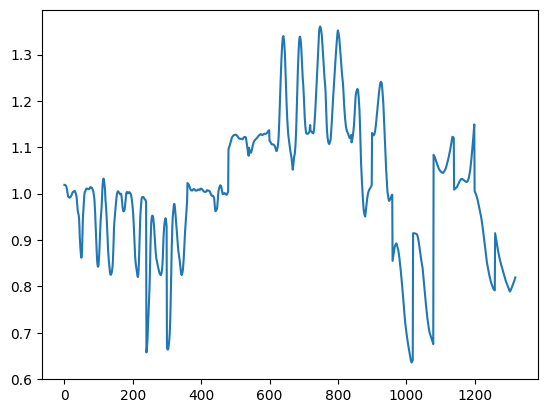

[np.float64(1.018871166975462), np.float64(1.0187756112147175), np.float64(1.0185770451301137), np.float64(1.018204552770804), np.float64(1.0174939866491342), np.float64(1.0161503478991376), np.float64(1.01427960244104), np.float64(1.010888274730134), np.float64(1.0067174302454667), np.float64(1.0021427660916904), np.float64(0.9969253854073402), np.float64(0.9937967761289375), np.float64(0.9927304141751364), np.float64(0.9923980693684592), np.float64(0.9919227175324806), np.float64(0.9913741059551755), np.float64(0.9915615668822861), np.float64(0.9919726137105602), np.float64(0.9927515120735493), np.float64(0.9939352684282858), np.float64(0.995206714151899), np.float64(0.9965582687714749), np.float64(0.998495406941179), np.float64(1.0007330794181781), np.float64(1.0027346077263237), np.float64(1.003368687522281), np.float64(1.0040091233764346), np.float64(1.0046577578279914), np.float64(1.0052636496460898), np.float64(1.0057856848148732), np.float64(1.0062516913187063), np.float64(1.00

In [62]:
longstring = []
note_start_end = []  # This will store (original_note_index, start_in_longstring)
for idx, note in enumerate(normalized_notes):
    interpolated = interpolate_with_nans(note, 60)
    note_start_end.append((recovered_removed_segments[idx][0],recovered_removed_segments[idx][1]))  # i.e., where this note begins
    longstring += list(interpolated)

def interpolate_with_nans(data, target_length=128):

    data = np.array(data, dtype=np.float64)
    original_length = len(data)
    x_original = np.linspace(0, 1, original_length)
    x_target = np.linspace(0, 1, target_length)
    valid = ~np.isnan(data)
    if np.count_nonzero(valid) < 2:
        return np.full(target_length, np.nan)
    interpolator = interp1d(x_original[valid], data[valid], kind='linear', bounds_error=False, fill_value="extrapolate")
    interpolated = interpolator(x_target)
    nan_mask_original = np.isnan(data)
    nan_mask_interpolated = np.interp(x_target, x_original, nan_mask_original.astype(float)) > 0.5
    interpolated[nan_mask_interpolated] = np.nan
    return interpolated
plt.plot(longstring)
plt.show()

print(longstring)
print(note_start_end)



Iteration 1/1 — Window Size: 60


100%|██████████| 21/21 [00:00<00:00, 37.58it/s]

  Clusters found: 9, removed some segments.


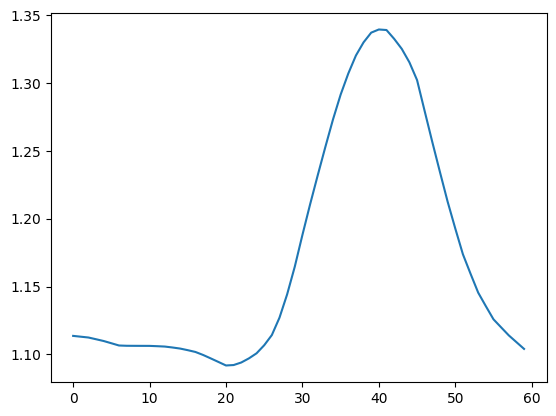

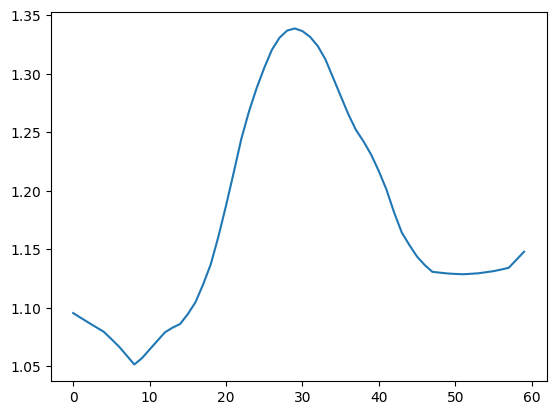

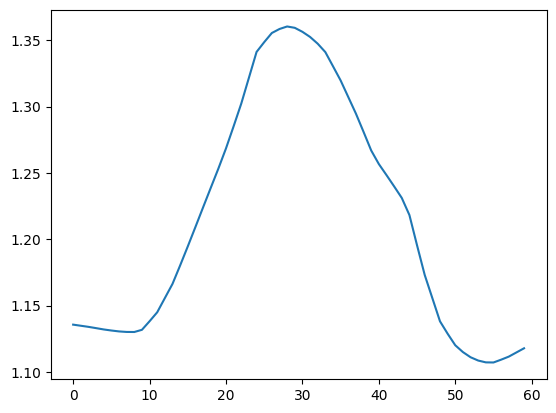

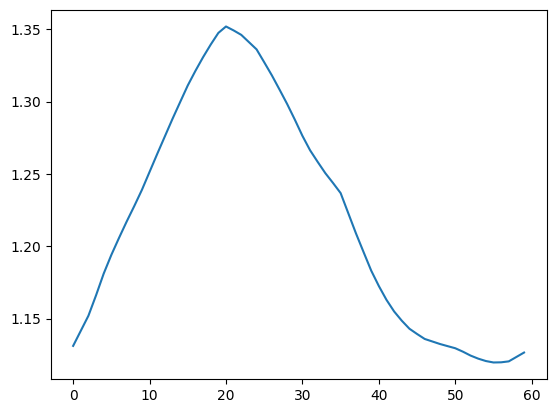

In [86]:
def non_overlapping_segments(conf, window_size, hop_size):
    segments = []
    indices = []
    i = 0
    while i < len(conf) - window_size:
        segment = conf[i:i + window_size]
        if np.isnan(segment).any():
            i += hop_size
            continue
        segments.append(segment)
        indices.append(i)
        i += window_size  # skip all overlapping windows
    return np.array(segments), np.array(indices)

def dtw_distance_matrix(segments):
    n = len(segments)
    dists = np.zeros((n, n))
    for i in tqdm(range(n)):
        for j in range(i+1, n):
            dist, _ = fastdtw(segments[i], segments[j])
            dists[i, j] = dist
            dists[j, i] = dist
    return dists

def extract_notes_from_conf(conf, initial_window_size, decay_size, min_window_size, outlier_threshold,similairity_threshold=100):
    conf = conf.copy()
    remaining_conf = conf.copy()
    all_removed_segments = []

    window_size = initial_window_size
    global_label_offset = 0

    total_iters = (initial_window_size - min_window_size) // decay_size + 1
    iter_count = 0

    while window_size >= min_window_size:
        iter_count += 1
        print(f"Iteration {iter_count}/{total_iters} — Window Size: {window_size}")

        hop_size = int(window_size)
        segments, segment_starts = non_overlapping_segments(remaining_conf, window_size, hop_size)
        
        if len(segments) == 0:
            print("  Skipped — no valid segments")
            window_size -= decay_size
            continue

        dtw_dists = dtw_distance_matrix(segments)

        if len(segments) < 2:
            return remaining_conf, all_removed_segments  # <-- add this safeguard

        clustering = AgglomerativeClustering(
            n_clusters=None,
            distance_threshold=similairity_threshold,
            metric='precomputed',
            linkage='average'
        )
        labels = clustering.fit_predict(dtw_dists)
        labels = clustering.fit_predict(dtw_dists)

        cluster_dict = defaultdict(list)
        cluster_origins = defaultdict(list)

        for seg, start_idx, lbl in zip(segments, segment_starts, labels):
            cluster_dict[lbl].append(seg)
            cluster_origins[lbl].append(start_idx)

        clustered = False
        for label, starts in cluster_origins.items():
            if len(starts) >= outlier_threshold:
                clustered = True
                global_label = global_label_offset + label
                for i in starts:
                    remaining_conf[i:i + window_size] = np.full(window_size, np.nan)
                    all_removed_segments.append((i, i + window_size, global_label))

        if clustered:
            print(f"  Clusters found: {len(set(labels))}, removed some segments.")
        else:
            print(f"  Clusters found: {len(set(labels))}, but none met the threshold.")

        global_label_offset += len(set(labels))
        window_size -= decay_size

    return remaining_conf, all_removed_segments

def plot_colored_segments(original_conf, removed_segments, residual_conf=None):
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import matplotlib.colors as mcolors

    # Assign a color to each cluster
    cluster_labels = sorted(set(lbl for _, _, lbl in removed_segments))
    cmap = cm.get_cmap('tab20', len(cluster_labels))
    cluster_to_color = {label: cmap(i) for i, label in enumerate(cluster_labels)}

    plt.figure(figsize=(14, 5))
    plt.plot(original_conf, label="Original", alpha=0.2, color='gray')

    # Plot segments grouped by cluster label
    for start, end, label in removed_segments:
        plt.plot(range(start, end), original_conf[start:end], color=cluster_to_color[label], label=f"Cluster {label}")

    # Plot residual if given
    if residual_conf is not None:
        plt.plot(residual_conf, label="Residual", linewidth=2, color='black')

    # Create a legend without duplicate labels
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.title("Clusters of Repeating Notes")
    plt.xlabel("Time Index")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

residual_conf, phase2_removed_segments = extract_notes_from_conf(
    conf=longstring,
    initial_window_size=60,
    decay_size=60,
    min_window_size=60,
    outlier_threshold=2,
    similairity_threshold=2)



# plot_colored_segments(longstring, phase2_removed_segments, residual_conf)

for i in range(len(phase2_removed_segments)):
    if phase2_removed_segments[i][2]==2:
        plt.plot(longstring[phase2_removed_segments[i][0]:phase2_removed_segments[i][1]])
        plt.show()
        play_segment(y, sr, note_start_end[i][0], note_start_end[i][1])




In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from tqdm import tqdm
# from scipy.spatial.distance import cdist
# from fastdtw import fastdtw
# from sklearn.cluster import AgglomerativeClustering
# from collections import defaultdict
# import librosa
# import IPython.display as ipd

# # STEP 1: Normalize by tonic
# conf2 = []
# for i in conf:
#     conf2.append(i / get_carnatic_frequencies("C#3")["Sa"])

# # ========== Helper Functions ==========

# def non_overlapping_segments(conf, window_size, hop_size):
#     segments = []
#     indices = []
#     i = 0
#     while i < len(conf) - window_size:
#         segment = conf[i:i + window_size]
#         if np.isnan(segment).any():
#             i += hop_size
#             continue
#         segments.append(segment)
#         indices.append(i)
#         i += window_size
#     return np.array(segments), np.array(indices)

# def dtw_distance_matrix(segments):
#     n = len(segments)
#     dists = np.zeros((n, n))
#     for i in tqdm(range(n)):
#         for j in range(i + 1, n):
#             dist, _ = fastdtw(segments[i], segments[j])
#             dists[i, j] = dist
#             dists[j, i] = dist
#     return dists

# def extract_notes_from_conf(conf, initial_window_size, decay_size, min_window_size, outlier_threshold, similairity_threshold=100):
#     conf = conf.copy()
#     remaining_conf = conf.copy()
#     all_removed_segments = []

#     window_size = initial_window_size
#     global_label_offset = 0

#     total_iters = (initial_window_size - min_window_size) // decay_size + 1
#     iter_count = 0

#     while window_size >= min_window_size:
#         iter_count += 1
#         print(f"Iteration {iter_count}/{total_iters} — Window Size: {window_size}")

#         hop_size = int(window_size / 12)
#         segments, segment_starts = non_overlapping_segments(remaining_conf, window_size, hop_size)

#         if len(segments) == 0:
#             print("  Skipped — no valid segments")
#             window_size -= decay_size
#             continue

#         dtw_dists = dtw_distance_matrix(segments)

#         if len(segments) < 2:
#             return remaining_conf, all_removed_segments

#         clustering = AgglomerativeClustering(
#             n_clusters=None,
#             distance_threshold=similairity_threshold,
#             metric='precomputed',
#             linkage='average'
#         )
#         labels = clustering.fit_predict(dtw_dists)

#         cluster_dict = defaultdict(list)
#         cluster_origins = defaultdict(list)

#         for seg, start_idx, lbl in zip(segments, segment_starts, labels):
#             cluster_dict[lbl].append(seg)
#             cluster_origins[lbl].append(start_idx)

#         clustered = False
#         for label, starts in cluster_origins.items():
#             if len(starts) >= outlier_threshold:
#                 clustered = True
#                 global_label = global_label_offset + label
#                 for i in starts:
#                     remaining_conf[i:i + window_size] = np.full(window_size, np.nan)
#                     all_removed_segments.append((i, i + window_size, global_label))

#         if clustered:
#             print(f"  Clusters found: {len(set(labels))}, removed some segments.")
#         else:
#             print(f"  Clusters found: {len(set(labels))}, but none met the threshold.")

#         global_label_offset += len(set(labels))
#         window_size -= decay_size

#     return remaining_conf, all_removed_segments

# def plot_colored_segments(original_conf, removed_segments, residual_conf=None):
#     import matplotlib.cm as cm
#     import matplotlib.colors as mcolors

#     cluster_labels = sorted(set(lbl for _, _, lbl in removed_segments))
#     cmap = cm.get_cmap('tab20', len(cluster_labels))
#     cluster_to_color = {label: cmap(i) for i, label in enumerate(cluster_labels)}

#     plt.figure(figsize=(14, 5))
#     plt.plot(original_conf, label="Original", alpha=0.2, color='gray')

#     for start, end, label in removed_segments:
#         plt.plot(range(start, end), original_conf[start:end], color=cluster_to_color[label], label=f"Cluster {label}")

#     if residual_conf is not None:
#         plt.plot(residual_conf, label="Residual", linewidth=2, color='black')

#     handles, labels = plt.gca().get_legend_handles_labels()
#     by_label = dict(zip(labels, handles))
#     plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

#     plt.title("Clusters of Repeating Notes")
#     plt.xlabel("Time Index")
#     plt.ylabel("Frequency")
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

# def play_segment(beat_audio, beat_sr, start_frame, end_frame):
#     start_time = librosa.frames_to_time(start_frame, sr=beat_sr)
#     end_time = librosa.frames_to_time(end_frame, sr=beat_sr)
#     start_sample = int(start_time * beat_sr)
#     end_sample = int(end_time * beat_sr)
#     audio_segment = beat_audio[start_sample:end_sample]
#     ipd.display(ipd.Audio(audio_segment, rate=beat_sr))

# # ========== Step 1: First Pass ==========

# residual_conf, removed_segments = extract_notes_from_conf(
#     conf=conf2[0:8000],
#     initial_window_size=60,
#     decay_size=2,
#     min_window_size=20,
#     outlier_threshold=2,
#     similairity_threshold=0.1
# )

# # plot_colored_segments(conf2[0:8000], removed_segments, residual_conf)

# # ========== Step 2: Interpolation & Second Clustering ==========

# interpolated_segments = []
# original_segment_info = []

# for (start, end, label) in removed_segments:
#     segment = conf2[start:end]
#     if len(segment) < 5:
#         continue
#     interpolated = np.interp(np.linspace(0, len(segment) - 1, 60), np.arange(len(segment)), segment)
#     interpolated_segments.append(interpolated)
#     original_segment_info.append((start, end, label))

# interpolated_segments = np.array(interpolated_segments)
# dtw_dists2 = dtw_distance_matrix(interpolated_segments)

# final_clustering = AgglomerativeClustering(
#     n_clusters=None,
#     distance_threshold=2,
#     metric='precomputed',
#     linkage='average'
# )
# final_labels = final_clustering.fit_predict(dtw_dists2)

# final_cluster_map = defaultdict(list)
# for i, lbl in enumerate(final_labels):
#     start, end, original_label = original_segment_info[i]
#     final_cluster_map[lbl].append((start, end, original_label))

# # ========== Step 3: Playback Test ==========

# # Example: Play two segments from final cluster 3 (change cluster number if needed)
# cluster_num = 3
# print(f"Final cluster {cluster_num} has {len(final_cluster_map[cluster_num])} segments")

# play_segment(y, sr, final_cluster_map[cluster_num][0][0], final_cluster_map[cluster_num][0][1])
# play_segment(y, sr, final_cluster_map[cluster_num][1][0], final_cluster_map[cluster_num][1][1])


Iteration 1/21 — Window Size: 60


100%|██████████| 111/111 [00:14<00:00,  7.41it/s]


  Clusters found: 111, but none met the threshold.
Iteration 2/21 — Window Size: 58


100%|██████████| 117/117 [00:15<00:00,  7.53it/s]


  Clusters found: 117, but none met the threshold.
Iteration 3/21 — Window Size: 56


100%|██████████| 122/122 [00:17<00:00,  7.14it/s]


  Clusters found: 122, but none met the threshold.
Iteration 4/21 — Window Size: 54


100%|██████████| 127/127 [00:17<00:00,  7.37it/s]


  Clusters found: 127, but none met the threshold.
Iteration 5/21 — Window Size: 52


100%|██████████| 130/130 [00:17<00:00,  7.36it/s]


  Clusters found: 130, but none met the threshold.
Iteration 6/21 — Window Size: 50


100%|██████████| 138/138 [00:18<00:00,  7.54it/s]


  Clusters found: 138, but none met the threshold.
Iteration 7/21 — Window Size: 48


100%|██████████| 145/145 [00:18<00:00,  7.75it/s]


  Clusters found: 145, but none met the threshold.
Iteration 8/21 — Window Size: 46


100%|██████████| 153/153 [00:17<00:00,  8.80it/s]


  Clusters found: 153, but none met the threshold.
Iteration 9/21 — Window Size: 44


100%|██████████| 157/157 [00:20<00:00,  7.67it/s]


  Clusters found: 157, but none met the threshold.
Iteration 10/21 — Window Size: 42


100%|██████████| 169/169 [00:22<00:00,  7.43it/s]


  Clusters found: 169, but none met the threshold.
Iteration 11/21 — Window Size: 40


100%|██████████| 174/174 [00:22<00:00,  7.60it/s]


  Clusters found: 173, removed some segments.
Iteration 12/21 — Window Size: 38


100%|██████████| 181/181 [00:23<00:00,  7.84it/s]


  Clusters found: 181, but none met the threshold.
Iteration 13/21 — Window Size: 36


100%|██████████| 194/194 [00:24<00:00,  8.04it/s]


  Clusters found: 193, removed some segments.
Iteration 14/21 — Window Size: 34


100%|██████████| 204/204 [00:26<00:00,  7.64it/s]


  Clusters found: 202, removed some segments.
Iteration 15/21 — Window Size: 32


100%|██████████| 208/208 [00:26<00:00,  7.79it/s]


  Clusters found: 206, removed some segments.
Iteration 16/21 — Window Size: 30


100%|██████████| 216/216 [08:01<00:00,  2.23s/it]


  Clusters found: 216, but none met the threshold.
Iteration 17/21 — Window Size: 28


100%|██████████| 235/235 [00:18<00:00, 12.47it/s]


  Clusters found: 230, removed some segments.
Iteration 18/21 — Window Size: 26


100%|██████████| 242/242 [00:18<00:00, 13.16it/s]


  Clusters found: 238, removed some segments.
Iteration 19/21 — Window Size: 24


100%|██████████| 256/256 [00:18<00:00, 13.62it/s]


  Clusters found: 249, removed some segments.
Iteration 20/21 — Window Size: 22


100%|██████████| 262/262 [00:17<00:00, 15.40it/s]


  Clusters found: 256, removed some segments.
Iteration 21/21 — Window Size: 20


100%|██████████| 276/276 [00:17<00:00, 15.58it/s]


  Clusters found: 263, removed some segments.


100%|██████████| 79/79 [00:07<00:00, 10.42it/s]

Final cluster 3 has 4 segments
